In [2]:
import sys
sys.path.append("../mypkg")

In [3]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [6]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [30]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras

def _add_res(res, key):
    if key not in res.keys():
        return None
    all_res["Len"].append(res[key][-1])
    all_res["ITE"].append(res[key][0][0])
    all_res["CATE"].append(res[key][0][1])
    all_res["method"].append(key)
    for ky, v in cur_paras.items():
        all_res[ky].append(v)

        
setting = "setting4"
d = 10
#res_dir = RES_ROOT/"demodp0mysettingtest_ablation_setting1_d10_n3000"
res_dir = RES_ROOT/f"simu_ablation_{setting}fixed_d{d}_n3000_noearly"
all_fils = list(res_dir.glob("*n_T-*.pkl"));
all_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="DDPM")
    _add_res(res, key="DDPM_sel")
    _add_res(res, key="DDPM_val")
    _add_res(res, key="DDPM_sel_val")
    _add_res(res, key="CQR")
all_res_df = pd.DataFrame(all_res);

#all_res_df = pd.concat([all_res_df1, all_res_df]);
def _fn(x):
    if "sel" in x:
        x = f"3-{x}"
    elif x.endswith("CQR"):
        x = f"1-{x}"
    else:
        x = f"2-{x}"
    return x
all_res_df["method1"] = all_res_df["method"].map(_fn)

In [31]:
# check all hyper-param combos
grp_var = ["n_T", "n_infeat", "upblk",  "downblk", "weight_decay",  "lr"]
all_res_df[all_res_df["method"] == "DDPM"].groupby(grp_var)[["ITE"]].agg(["count"])

ITE
                                                  count
n_T     n_infeat upblk downblk weight_decay lr         
100.000 128.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                 3.000 3.000   0.010        0.010    50
                                            0.100    50
                 5.000 5.000   0.010        0.010    50
                                            0.100    50
        512.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                 3.000 3.000   0.010        0.010    50
                                            0.100    50
                 5.000 5.000   0.010        0.010    50
                                            0.100    50
200.000 128.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                 3.000 3.000   0.010        0.010    50
                                            0.100    50
                 5.000 5.000   0.010        0.010    50
                                            0.100    50
        512.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                 3.000 3.000   0.010        0.010    20
                                            0.100    50

# Select com for each rep

In [32]:
best_res = []
for cur_rep in list(set(all_res_df["rep"])):
    kpidx = np.bitwise_and(all_res_df["rep"] == cur_rep, all_res_df["method"].isin(["DDPM_val", "DDPM_sel_val"]));
    kpidx = np.bitwise_and(kpidx, all_res_df["ITE"]>0.95)
    if kpidx.sum() == 0:
        kpidx = np.bitwise_and(all_res_df["rep"] == cur_rep, all_res_df["method"].isin(["DDPM_val", "DDPM_sel_val"]))
    
    best_val = all_res_df[kpidx].sort_values(by="Len").iloc[0]
    cols = ["method", "lr", "n_infeat", "n_T", "weight_decay", "upblk", "downblk", "rep"]
    mask = np.ones(all_res_df.shape[0], dtype=bool)
    mask_cqr = np.ones(all_res_df.shape[0], dtype=bool)
    for col in cols:
        if col.startswith("method"):
            #v = best_val[col]
            v = best_val[col].split("_val")[0]
            mask = np.bitwise_and(mask, all_res_df[col].isin([v, "CQR"]))
        else: 
            v = best_val[col]
            mask = np.bitwise_and(mask, all_res_df[col] == v)
    best_res.append(all_res_df[mask])
best_res = pd.concat(best_res);
best_res["method2"] = best_res["method"].map(lambda x: x.split("_")[0])
best_res.groupby("method2")[["Len", "ITE"]].agg(["mean", "median", "std", "count"])

Len                      ITE                   
         mean median   std count  mean median   std count
method2                                                  
CQR     2.758  2.800 0.326    50 0.956  0.961 0.018    50
DDPM    3.213  3.129 0.577    50 0.956  0.954 0.010    50

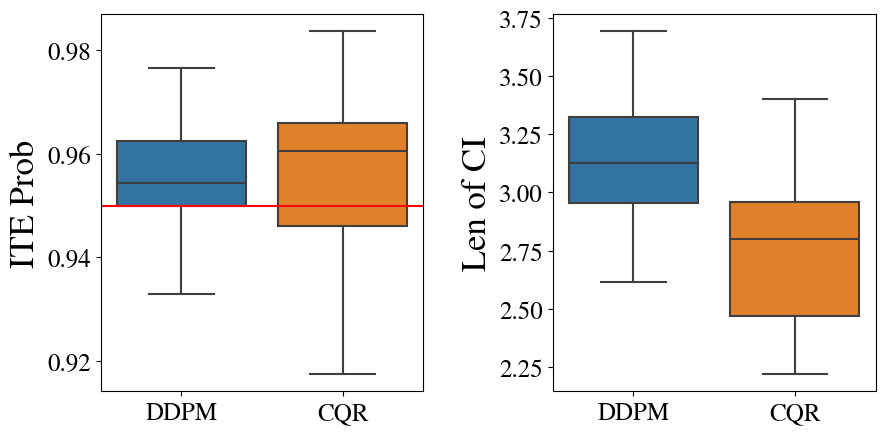

In [33]:
plt.subplot(121)
sns.boxplot(data=best_res, y="ITE", x="method2", showfliers=False)
plt.axhline(y=0.95, color="red");
plt.xlabel("")
plt.ylabel("ITE Prob")
plt.subplot(122)
sns.boxplot(data=best_res, y="Len", x="method2", showfliers=False)
plt.xlabel("")
plt.ylabel("Len of CI");
plt.savefig(FIG_ROOT/f"Results_{setting}_d{d}.jpg")

# Select com by mean

In [34]:
res_df = all_res_df.groupby(["n_infeat", "upblk", 
                             "downblk", "weight_decay", 
                             "lr", "n_T",   "method1"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"]);

base_idxs = np.bitwise_and(res_df[('Len',  'count')] == 50, res_df.index.map(lambda x: "CQR" in x[-1]))

val_df = res_df[res_df.index.map(lambda x: "val" in x[-1])]
sorted_val_idx = val_df[("Len", "median")].sort_values().index
sorted_test_idx = pd.MultiIndex.from_tuples([tuple(list(ix[:-1])+[ix[-1].split("_val")[0]]) for ix in sorted_val_idx], 
                                            names=sorted_val_idx.names);

pd.concat([res_df[base_idxs].iloc[:1],  res_df.loc[sorted_test_idx]]).head(n=30)

Len         \
                                                              mean median   
n_infeat upblk downblk weight_decay lr    n_T     method1                   
128.000  1.000 1.000   0.010        0.010 100.000 1-CQR      2.758  2.800   
512.000  3.000 3.000   0.010        0.010 200.000 3-DDPM_sel 3.414  3.290   
128.000  5.000 5.000   0.010        0.010 200.000 3-DDPM_sel 3.532  3.368   
512.000  1.000 1.000   0.010        0.010 200.000 3-DDPM_sel 3.582  3.505   
128.000  3.000 3.000   0.010        0.010 200.000 3-DDPM_sel 3.588  3.437   
         5.000 5.000   0.010        0.010 100.000 3-DDPM_sel 3.944  3.458   
         1.000 1.000   0.010        0.010 200.000 3-DDPM_sel 3.631  3.632   
512.000  3.000 3.000   0.010        0.010 100.000 3-DDPM_sel 3.919  3.671   
128.000  3.000 3.000   0.010        0.010 100.000 3-DDPM_sel 3.988  3.838   
512.000  3.000 3.000   0.010        0.100 200.000 3-DDPM_sel 4.187  3.887   
128.000  3.000 3.000   0.010        0.100 200.000 3-DDPM_sel 4.249  3.865   
         5.000 5.000   0.010        0.100 200.000 3-DDPM_sel 4.036  3.942   
                                          100.000 3-DDPM_sel 4.338  4.010   
         1.000 1.000   0.010        0.010 100.000 3-DDPM_sel 4.037  4.018   
         3.000 3.000   0.010        0.100 100.000 3-DDPM_sel 4.307  3.973   
512.000  1.000 1.000   0.010        0.010 100.000 3-DDPM_sel 4.078  4.202   
                                    0.100 200.000 3-DDPM_sel 4.349  4.094   
128.000  1.000 1.000   0.010        0.100 200.000 3-DDPM_sel 4.229  4.194   
512.000  3.000 3.000   0.010        0.100 100.000 3-DDPM_sel 4.379  4.243   
         5.000 5.000   0.010        0.010 100.000 3-DDPM_sel 4.117  4.376   
128.000  1.000 1.000   0.010        0.010 100.000 2-DDPM     4.803  4.533   
512.000  3.000 3.000   0.010        0.010 200.000 2-DDPM     4.660  4.582   
         1.000 1.000   0.010        0.100 100.000 3-DDPM_sel 4.568  4.661   
128.000  5.000 5.000   0.010        0.100 100.000 2-DDPM     5.140  4.669   
512.000  1.000 1.000   0.010        0.010 200.000 2-DDPM     4.639  4.719   
128.000  1.000 1.000   0.010        0.100 100.000 3-DDPM_sel 4.502  4.728   
512.000  5.000 5.000   0.010        0.100 100.000 3-DDPM_sel 4.637  4.849   
         3.000 3.000   0.010        0.010 100.000 2-DDPM     4.881  4.763   
128.000  1.000 1.000   0.010        0.010 200.000 2-DDPM     4.708  4.815   
         5.000 5.000   0.010        0.010 100.000 2-DDPM     4.982  4.863   

                                                                          \
                                                               std count   
n_infeat upblk downblk weight_decay lr    n_T     method1                  
128.000  1.000 1.000   0.010        0.010 100.000 1-CQR      0.326    50   
512.000  3.000 3.000   0.010        0.010 200.000 3-DDPM_sel 0.592    20   
128.000  5.000 5.000   0.010        0.010 200.000 3-DDPM_sel 0.600    50   
512.000  1.000 1.000   0.010        0.010 200.000 3-DDPM_sel 0.549    50   
128.000  3.000 3.000   0.010        0.010 200.000 3-DDPM_sel 0.616    50   
         5.000 5.000   0.010        0.010 100.000 3-DDPM_sel 0.989    50   
         1.000 1.000   0.010        0.010 200.000 3-DDPM_sel 0.582    50   
512.000  3.000 3.000   0.010        0.010 100.000 3-DDPM_sel 0.971    50   
128.000  3.000 3.000   0.010        0.010 100.000 3-DDPM_sel 0.950    50   
512.000  3.000 3.000   0.010        0.100 200.000 3-DDPM_sel 0.884    50   
128.000  3.000 3.000   0.010        0.100 200.000 3-DDPM_sel 0.880    50   
         5.000 5.000   0.010        0.100 200.000 3-DDPM_sel 0.685    50   
                                          100.000 3-DDPM_sel 1.145    50   
         1.000 1.000   0.010        0.010 100.000 3-DDPM_sel 0.889    50   
         3.000 3.000   0.010        0.100 100.000 3-DDPM_sel 0.959    50   
512.000  1.000 1.000   0.010        0.010 100.000 3-DDPM_sel 0.911    50   
                                    0.100 200.000 3-DDPM_sel 0.828    50   
1

In [34]:
#res_df.to_html("all_res.html");
#pd.set_option('display.float_format', '{:.3f}'.format)


In [35]:
grp_var = ["n_infeat", "upblk",  "downblk", "weight_decay",  "lr", "n_T",   "method1"]
grp_var = [ "method1"]
agg_var = ["mean", "median", "std", "count"]
res_df = all_res_df[all_res_df["method1"].map(lambda x: "DDPM" in x)].groupby(grp_var)[["Len", "ITE"]].agg(agg_var);
res_df

Len                      ITE                   
                mean median   std count  mean median   std count
method1                                                         
2-DDPM         5.816  5.322 2.980    82 0.953  0.954 0.013    82
2-DDPM_val     5.792  5.327 2.950    82 0.949  0.952 0.020    82
3-DDPM_sel     4.920  4.724 1.109    82 0.953  0.956 0.013    82
3-DDPM_sel_val 4.904  4.708 1.100    82 0.949  0.952 0.019    82

# Get result under best combone

In [26]:
def get_res_at_com(all_res_df, com):
    kpidx = np.ones(all_res_df.shape[0], dtype=bool)
    for ky, v in com.items():
        if ky == "method":
            continue
        kpidx = np.bitwise_and(kpidx,all_res_df[ky] == v)
    return all_res_df[kpidx]

In [27]:
best_com = dict()
best_com["n_infeat"] = 128
best_com["upblk"] = 3
best_com["downblk"] = 3
best_com["weight_decay"] = 0.01
best_com["lr"] = 0.01
best_com["n_T"] = 100
best_com["method"] = "DDPM_sel"

In [22]:
res_df = get_res_at_com(all_res_df, best_com);
res_df = res_df[res_df["method"].isin(["CQR", best_com['method']])]
res_df.head()

,Len,ITE,CATE,method,lr,n_infeat,n_T,weight_decay,upblk,downblk,rep
19,6.524714,0.923,0.998,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,32
20,5.465805,0.944,0.998,CQR,0.01,128.0,100.0,0.01,3.0,3.0,32
25,9.175587,0.957,0.981,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,0
26,5.459108,0.934,1.000,CQR,0.01,128.0,100.0,0.01,3.0,3.0,0
34,9.436742,0.958,0.980,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,38


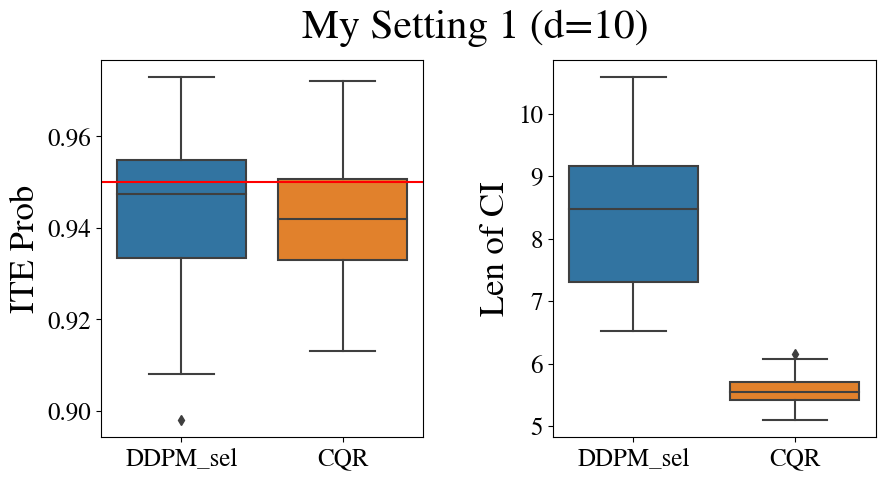

In [23]:
plt.suptitle(f"My Setting 1 (d=10)", fontsize=30)
plt.subplot(121)
sns.boxplot(data=res_df, y="ITE", x="method")
plt.axhline(y=0.95, color="red");
plt.xlabel("")
plt.ylabel("ITE Prob")
plt.subplot(122)
sns.boxplot(data=res_df, y="Len", x="method")
plt.xlabel("")
plt.ylabel("Len of CI");